# Using Engines and Degraders to Generate Galaxy Samples with Errors and Biases

author: John Franklin Crenshaw, Sam Schmidt, Eric Charles, others...

last run successfully: March 16, 2022

This notebook demonstrates how to use a RAIL Engines to create galaxy samples, and how to use Degraders to add various errors and biases to the sample.

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the Engine. This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will first learn how to draw samples from a RAIL Engine object.
Then we will demonstrate how to use the following RAIL Degraders:
1. [**LSSTErrorModel**](#LSSTErrorModel), which adds photometric errors
2. [**QuantityCut**](#QuantityCut), which applies cuts to the specified columns of the sample
3. [**InvRedshiftIncompleteness**](#InvRedshiftIncompleteness), which introduces sample incompleteness
4. [**LineConfusion**](#LineConfusion), which introduces spectroscopic errors

Throughout the notebook, we will show how you can chain all these Degraders together to build a more complicated degrader.
Hopefully, this will allow you to see how you can build your own degrader.

*Note on generating redshift posteriors*: regardless of what Degraders you apply, when you use a Creator to estimate posteriors, the posteriors will *always* be calculated with respect to the "true" distribution. This is the whole point of the Creation Module -- you can generate degraded samples for which we still have access to the *true* posteriors. For an example of how to calculate posteriors, see `posterior-demo.ipynb`.

In [1]:
import matplotlib.pyplot as plt
from pzflow.examples import get_example_flow
from rail.creation import engines
from rail.core.stage import RailStage
from rail.creation.degradation import (
    InvRedshiftIncompleteness,
    LineConfusion,
    LSSTErrorModel,
    QuantityCut,
)

import pzflow
import os
flow_file = os.path.join(os.path.dirname(pzflow.__file__), 'examples', 'example-flow.pkl')

n_samples = int(1e5)
flowEngine_truth = engines.FlowEngine.make_stage(name='truth', flow=flow_file, n_samples=n_samples)

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

flowEngine_truth.get_data('flow')

samples_truth = flowEngine_truth.sample(n_samples, seed=0)
print(samples_truth.data)
print("Data was written to ", samples_truth.path)

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Inserting handle into data store.  flow: /net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/pzflow/examples/example-flow.pkl, truth
Inserting handle into data store.  output_truth: inprogress_output_truth.pq, truth
       redshift          u          g          r          i          z  \
0      0.654000  28.262444  27.335606  26.053682  25.258146  25.094685   
1      1.445551  24.633509  24.454756  24.367916  24.036932  23.744223   
2      0.980286  25.869593  25.591894  25.014988  24.306276  23.757196   
3      1.974136  25.846521  25.676571  25.428736  25.334469  25.052134   
4      1.573981  27.529625  27.227512  26.901337  26.430315  26.164469   
...         ...        ...        ...        ...        ...        ...   
99995  0.537298  28.622873  27.595121  26.410727  25.795841  25.547186   
99996  0.365364  28.490147  27.377586  26.312820  25.961052  25.675964   
99997  0.621117  27.889215  26.828249  25.556490  24.797277  24.600286   
99998  0.814658  27.9

import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/rail/creation/degradation')
#import lsst_error_model

from lsst_error_model import LSSTErrorModel



errorModel = LSSTErrorModel.make_stage(name='error_model')
samples_w_errs = errorModel(samples_truth)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/rail/creation/degradation')
import spec_selection_v2
#from importlib import reload
#reload(lsst_error_model_extended)
from spec_selection_v2 import *

#from lsst_error_model_extended import *
#from lsst_error_model import *



<a id="LSSTErrorModel"></a>
## Degrader 1: LSSTErrorModel

Now, we will demonstrate the `LSSTErrorModel`, which adds photometric errors using a model similar to the model from [Ivezic et al. 2019](https://arxiv.org/abs/0805.2366) (specifically, it uses the model from this paper, without making the high SNR assumption. To restore this assumption and therefore use the exact model from the paper, set `highSNR=True`.)

Let's create an error model with the default settings:

In [3]:
specselect = SpecSelection_DEEP2.make_stage(N_tot=100000)

To see the details of the model, including the default settings we are using, you can just print the model:

Now let's add this error model as a degrader and draw some samples with photometric errors.

In [4]:
samples_w_errs = specselect(samples_truth)
output = samples_w_errs.data

/net/home/fohlen13/yanza21/research/src/RAIL_new/RAIL/examples/creation
0
Inserting handle into data store.  output: inprogress_output.pq, specselection_deep2


In [5]:
import numpy as np


In [6]:
ri_out = output["r"].to_numpy() - output["i"].to_numpy()
gr_out = output["g"].to_numpy() - output["r"].to_numpy()

In [15]:
output

,redshift,u,g,r,i,z,y
26,0.984318,24.744576,24.370977,23.777340,23.220129,22.686823,22.488054
49,0.828350,25.239464,24.811348,23.937138,22.921108,22.526539,22.439432
74,0.361250,20.655273,19.684072,18.881357,17.737083,19.376541,19.293423
107,1.008930,25.780838,25.047359,23.988979,23.245798,22.467009,22.108677
115,0.871359,24.897449,24.517611,23.867508,23.017267,22.674503,22.581799
...,...,...,...,...,...,...,...
99891,0.789690,25.032787,24.533724,23.615498,22.607014,22.153299,21.961401
99895,0.624268,23.896418,23.518997,22.786623,22.065809,21.788555,21.594677
99965,0.639708,24.878908,23.983885,23.157145,22.444042,22.204350,22.013275
99967,0.662267,25.347988,23.645147,22.073593,20.916929,20.474640,20.198927


In [7]:
input = samples_truth.data
ri_in = input["r"].to_numpy() - input["i"].to_numpy()
gr_in = input["g"].to_numpy() - input["r"].to_numpy()

z_in = input["redshift"].to_numpy()

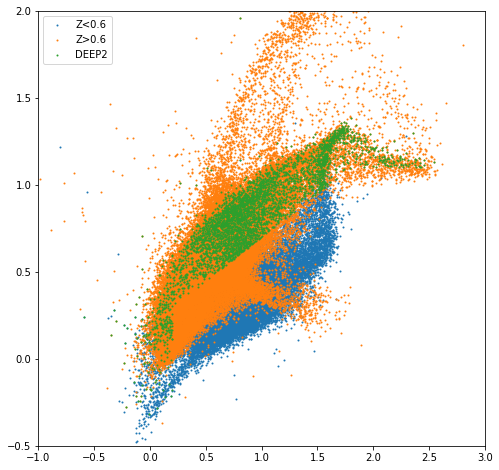

In [8]:
import matplotlib as mpl
import matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

x1 = np.linspace(-0.1, 0.5)
x2 = np.linspace(0.5, 2.5)

y2 = np.ones_like(x2) * 0.4
y1 = x1 - 0.1

x = np.hstack([x1, x2])
y = np.hstack([y1, y2])

fig = plt.figure(figsize = (8,8))

plt.scatter(gr_in[z_in<0.6], ri_in[z_in<0.6], s=1, label='Z<0.6')
plt.scatter(gr_in[z_in>0.6], ri_in[z_in>0.6], s=1, label='Z>0.6')
plt.scatter(gr_out, ri_out, s=1, label='DEEP2')
plt.ylim(-0.5,2)
plt.xlim(-1, 3)
#plt.plot(x, y, color='k')
plt.legend()
#plt.show()

Text(0.5, 0, 'Redshift')

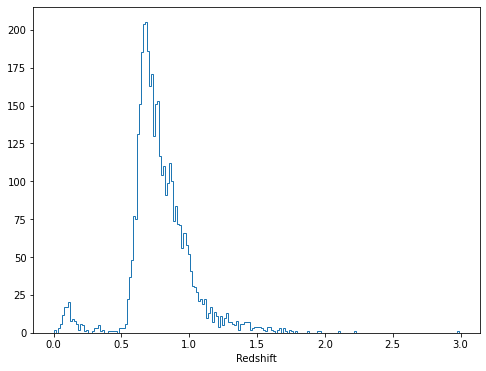

In [18]:
fig = plt.figure(figsize = (8,6))
h = plt.hist(output["redshift"].to_numpy(), histtype='step', bins=200)
plt.xlabel('Redshift')

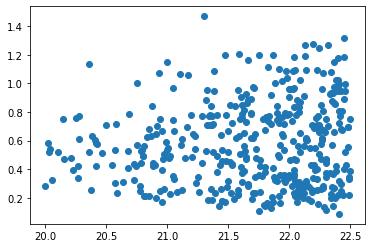

In [21]:
plt.scatter(output["r"].to_numpy(), output["r"].to_numpy()-output["i"].to_numpy())

In [9]:
from astropy.io import fits

mice2_file = fits.open('/net/home/fohlen13/yanza21/DATA/mocks/MICE2_KV450/SPECZ_magnification_on/WiggleZ/MICE2_masked_CC.fits')
mice2_r = mice2_file[1].data['sdss_r_obs_mag']
mice2_i = mice2_file[1].data['sdss_i_obs_mag']
mice2_g = mice2_file[1].data['sdss_g_obs_mag']

mask = (mice2_r<99)*(mice2_i<99)*(mice2_g<99)

mice2_gr = mice2_g - mice2_r
mice2_ri = mice2_r - mice2_i


In [10]:
from astropy.io import fits

mice2_file = fits.open('/net/home/fohlen13/yanza21/DATA/mocks/MICE2_KV450/SPECZ_magnification_on/WiggleZ/MICE2_WiggleZ_CC.fits')
mice2_r = mice2_file[1].data['sdss_r_obs_mag']
mice2_i = mice2_file[1].data['sdss_i_obs_mag']
mice2_g = mice2_file[1].data['sdss_g_obs_mag']

mask_wz = (mice2_r<99)*(mice2_i<99)*(mice2_g<99)

mice2_gr_wz = mice2_g - mice2_r
mice2_ri_wz = mice2_r - mice2_i


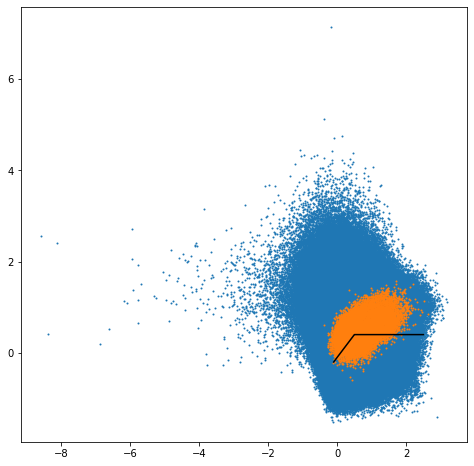

In [11]:
import matplotlib as mpl
import matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

x1 = np.linspace(-0.1, 0.5)
x2 = np.linspace(0.5, 2.5)

y2 = np.ones_like(x2) * 0.4
y1 = x1 - 0.1

x = np.hstack([x1, x2])
y = np.hstack([y1, y2])

fig = plt.figure(figsize = (8,8))

#plt.scatter(gr_in[z_in<0.6], ri_in[z_in<0.6], s=3, label='Z<0.6')
#plt.scatter(gr_in[z_in>0.6], ri_in[z_in>0.6], s=3, label='Z>0.6')
plt.scatter(mice2_gr[mask], mice2_ri[mask], s=1)
plt.scatter(mice2_gr_wz[mask_wz], mice2_ri_wz[mask_wz], s=1)
plt.plot(x, y, color='k')

#plt.show()

In [12]:
from astropy.io import fits

mice2_file = fits.open('/net/home/fohlen13/yanza21/DATA/mocks/MICE2_KV450/SPECZ_magnification_on/WiggleZ/MICE2_WiggleZ_CC.fits')
mice2_r_wz = mice2_file[1].data['sdss_r_obs_mag']
mice2_i_wz = mice2_file[1].data['sdss_i_obs_mag']
mice2_g_wz = mice2_file[1].data['sdss_g_obs_mag']

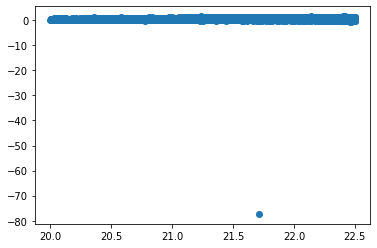

In [13]:
plt.scatter(mice2_r, mice2_r - mice2_i)

Notice some of the magnitudes are NaN's. These are non-detections. This means those observed magnitudes were beyond the 30mag limit that is default in `LSSTErrorModel`. 
You can change this limit and the corresponding flag by setting `magLim=...` and `ndFlag=...` in the constructor for `LSSTErrorModel`. 

Let's plot the error as a function of magnitude

KeyError: 'u_err'

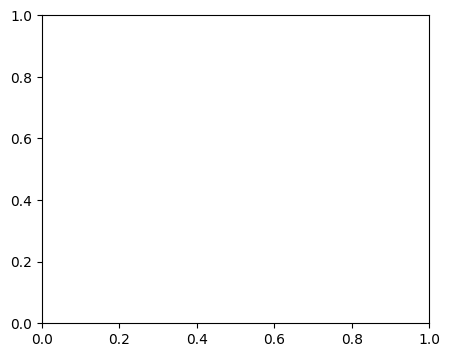

In [14]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

for band in "ugrizy":
    
    # pull out the magnitudes and errors
    mags = samples_w_errs.data[band].to_numpy()
    errs = samples_w_errs.data[band + "_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    ax.plot(mags, errs, label=band) 
    
ax.legend()
ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")


You can see that the photometric error increases as magnitude gets dimmer, just like you would expect. Notice, however, that we have galaxies as dim as magnitude 30. This is because the Flow produces a sample much deeper than the LSST 5-sigma limiting magnitudes. There are no galaxies dimmer than magnitude 30 because LSSTErrorModel sets magnitudes > 30 equal to NaN (the default flag for non-detections).

<a id="QuantityCut"></a>
## Degrader 2: QuantityCut

Recall how the sample above has galaxies as dim as magnitude 30. This is well beyond the LSST 5-sigma limiting magnitudes, so it will be useful to apply cuts to the data to filter out these super-dim samples. We can apply these cuts using the `QuantityCut` degrader. This degrader will cut out any samples that do not pass all of the specified cuts.

Let's make and run degraders that first adds photometric errors, then cuts at i<25.3, which is the LSST gold sample.

In [ ]:
gold_cut = QuantityCut.make_stage(name='cuts', cuts={"i": 25.3})                                

Now we can stick this into a Creator and draw a new sample

In [ ]:
samples_gold_w_errs = gold_cut(samples_w_errs)

If you look at the i column, you will see there are no longer any samples with i > 25.3. You can also see that despite making the cut on the i band, there are still 100000 samples as requested. This is because after making the cut, the creator will draw more samples (and re-apply the cut) iteratively until you have as many samples as originally requested. 

One more note: it is easy to use the QuantityCut degrader as a SNR cut on the magnitudes. The magnitude equation is $m = -2.5 \log(f)$. Taking the derivative, we have
$$
dm = \frac{2.5}{\ln(10)} \frac{df}{f} = \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
So if you want to make a cut on galaxies above a certain SNR, you can make a cut
$$
dm < \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
For example, an SNR cut on the i band would look like this: `QuantityCut({"i_err": 2.5/np.log(10) * 1/SNR})`.

<a id="InvRedshiftIncompleteness"></a>
## Degrader 3: InvRedshiftIncompleteness

Next, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

In [ ]:
inv_incomplete = InvRedshiftIncompleteness.make_stage(name='incompleteness', pivot_redshift=0.8)

In [ ]:
samples_incomplete_gold_w_errs = inv_incomplete(samples_gold_w_errs)

Let's plot the redshift distributions of the samples we have generated so far:

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth.data["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs.data["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs.data["redshift"], label="Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the Gold sample has significantly fewer high-redshift galaxies than the truth. This is because many of the high-redshift galaxies have i > 25.3.

You can further see that the Incomplete Gold sample has even fewer high-redshift galaxies. This is exactly what we expected from this degrader.

<a id="LineConfusion"></a>
## Degrader 4: LineConfusion

`LineConfusion` is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

For this example, let's use the degrader to simulate a scenario in which which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines. (note I do not know how realistic this scenario is!)

In [ ]:
OII = 3727
OIII = 5007

lc_2p_0II_0III = LineConfusion.make_stage(name='lc_2p_0II_0III',
                                          true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)
lc_1p_0III_0II = LineConfusion.make_stage(name='lc_1p_0III_0II',
                                          true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)

In [ ]:
samples_conf_inc_gold_w_errs = lc_1p_0III_0II(lc_2p_0II_0III(samples_incomplete_gold_w_errs))

Let's plot the redshift distributions one more time

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth.data["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs.data["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs.data["redshift"], label="Incomplete Gold", **hist_settings)
ax.hist(samples_conf_inc_gold_w_errs.data["redshift"], label="Confused Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the redshift distribution of this new sample is essentially identical to the Incomplete Gold sample, with small perturbations that result from the line confusion. 

However the real impact of this degrader isn't on the redshift distribution, but rather that it introduces erroneous spec-z's into the photo-z training sets! To see the impact of this effect, let's plot the true spec-z's as present in the Incomplete Gold sample, vs the spec-z's listed in the new sample with Oxygen Line Confusion.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=85)

ax.scatter(samples_incomplete_gold_w_errs.data["redshift"], samples_conf_inc_gold_w_errs.data["redshift"], 
           marker=".", s=1)

ax.set(
    xlim=(0, 2.5), ylim=(0, 2.5),
    xlabel="True spec-z (in Incomplete Gold sample)",
    ylabel="Spec-z listed in the Confused sample",
)
plt.show()

Now we can clearly see the spec-z errors! The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.